In [1]:
import BGlib

In [3]:
dir(BGlib.be)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'analysis',
 'translators',
 'viz']

In [1]:
# BE mode : Band Excitation을 활용
import numpy as np
import matplotlib.pyplot as plt
import pyUSID as usid
import pycroscopy as px
import h5py
import time
import pickle
import os

In [18]:
import sidpy
h5_path = 'myfile_128.h5'
h5_file = h5py.File(h5_path,'r+')
main_dsets = usid.hdf_utils.get_all_main(h5_file)

In [19]:
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Fit
      ├ Fit-Loop_Fit_000
        ----------------
        ├ Fit
        ├ Guess
        ├ Spectroscopic_Indices
        ├ Spectroscopic_Values
      ├ Fit-Loop_Fit_001
        ----------------
        ├ Guess
        ├ Loop_Metrics
        ├ Loop_Metrics_Indices
        ├ Loop_Metrics_Values
        ├ Projected_Loops
      ├ Fit-Loop_Fit_002
        ----------------
        ├ Fit
        ├ Fit_Loop_Parameters
        ├ Guess
        ├ Guess_Loop_Parameters
        ├ Loop_Metrics
        ├ Loop_Metrics_Indices
        ├ Loop_Metrics_Values
        ├ Projected_Loops
        ├ completed_fit_positions
        ├ completed_guess_positions
        ├ completed_positions
      ├ Fit-Loop_Fit_003
        ----------------
        ├ Guess
        ├ Loop_Metrics
        ├ Loop_Metrics_Indices
        ├ Loo

In [20]:
# 16384 = 128*128 / 2368 = 2*32*37
main_dsets[0]

<HDF5 dataset "Raw_Data": shape (16384, 2368), type "<c8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Deflection (Volts) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 128 
	X - size: 128 
Spectroscopic Dimensions: 
	Field - size: 2 
	DC_Offset - size: 32 
	Frequency - size: 37
Data Type:
	complex64

In [43]:
# Data Field : V, Hz, Q , Phase, R2 criterion
# be_shotter.py를 보면 USID형식으로 변환후 진행
# 37개의 주파수에서 SHO fitting 진행
main_dsets[1]

<HDF5 dataset "Fit": shape (16384, 64), type "|V20">
located at: 
	/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Fit 
Data contains: 
	SHO Parameters (a.u.) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 128 
	X - size: 128 
Spectroscopic Dimensions: 
	Field - size: 2 
	DC_Offset - size: 32
Data Fields:
	Amplitude [V], Frequency [Hz], Quality Factor, Phase [rad], R2 Criterion

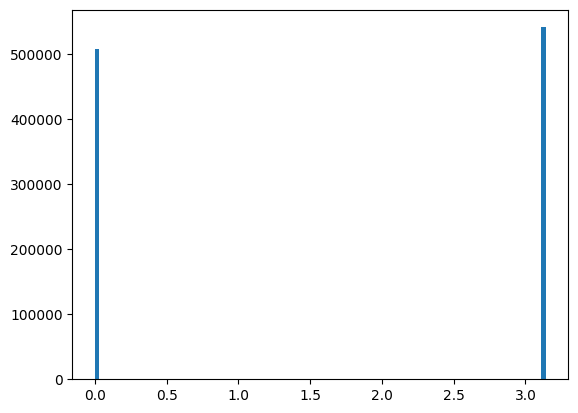

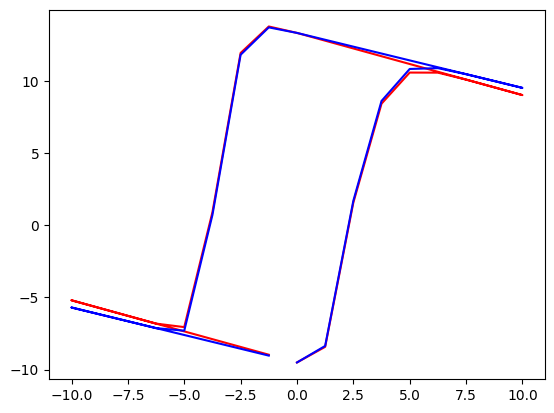

In [127]:
h5_sho_fit = main_dsets[1]
amplitude = h5_sho_fit['Amplitude [V]']
phase = h5_sho_fit['Phase [rad]']

# phase가 0과 3.14만 존재하는데 sho_fit이 잘못된 데이터 같다.
# sho_fit 된 데이터는 main_dsets안에 2개 있으나 하나는 아래와 같다.
# 다른 하나는 phase 최대값이 5e-08로 너무 작다. 그래프가 잘 그려지지않음.
adjust = np.max(phase) - np.min(phase)
phase_wrap = []
for ii in range(phase.shape[0]):
    phase_wrap.append([x+adjust if x < -2 else x for x in phase[ii,:]])
phase = np.asarray(phase_wrap)
plt.figure()
plt.hist(phase.ravel(),bins=100)

PR_mat = amplitude*np.cos(phase)
# reshape -> 128,128,64 (x,y,field 2 DC bias 32)
PR_mat = -PR_mat.reshape(h5_sho_fit.pos_dim_sizes[0],h5_sho_fit.pos_dim_sizes[1],-1 )
plt.figure() # 안해주면 위의 figure랑 같이 그려짐


# h5_sho_fit.h5_spec_vals의 데이터 형식은 (2,64)
# 앞에 0 32개 1 32개 / 뒤는 32 bias , 동일한 32 bias
# 아래 과정이 왜 필요한지는 현재까지 모르겠다.
# 결과적으로 동일한 내용을 포함 / 단순 32개의 bias를 저장한것이므로
dc_vec_OF = h5_sho_fit.h5_spec_vals[1][h5_sho_fit.h5_spec_vals[0]==0]
dc_vec_IF = h5_sho_fit.h5_spec_vals[1][h5_sho_fit.h5_spec_vals[0]==1]

PR_OF = PR_mat[:,:,::2]
PR_IF = PR_mat[:,:,1::2]

                                        
plt.plot(dc_vec_OF,PR_OF[110,98,:] , 'r-')
plt.plot(dc_vec_IF,PR_IF[110,98,:] , 'b-')


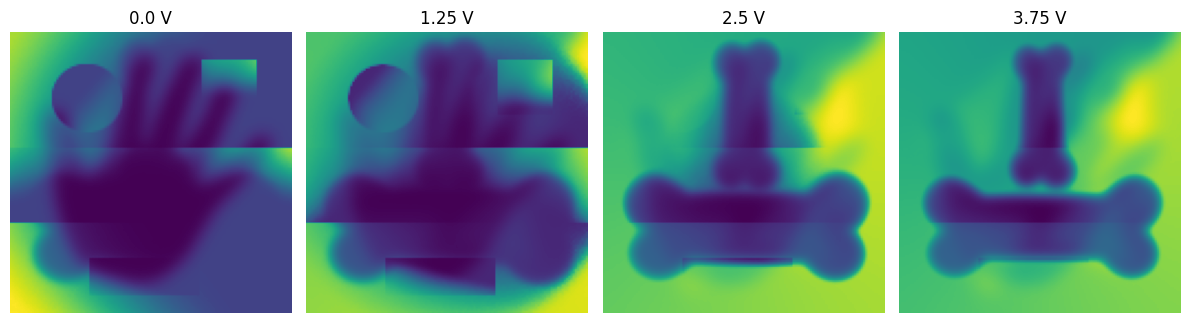

In [ ]:
plt.figure(figsize=(12, 6))  

for ind in range(4):
    plt.subplot(1, 4, ind + 1) 
    plt.imshow(PR_OF[:, :, ind], cmap='viridis') 
    plt.title(str(dc_vec_OF[ind]) + ' V')
    plt.axis("off") 

plt.tight_layout()
plt.show()

In [2]:
import sidpy
h5_path = 'PTO_BEPS_50x50_0002.h5'
h5_file = h5py.File(h5_path,'r+')
main_dsets = usid.hdf_utils.get_all_main(h5_file)

In [3]:
main_dsets[0]

<HDF5 dataset "Raw_Data": shape (2500, 12544), type "<c8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	quantity (a.u.) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 50 
	Y - size: 50 
Spectroscopic Dimensions: 
	Frequency - size: 49 
	DC_Offset - size: 64 
	Field - size: 2 
	Cycle - size: 2
Data Type:
	complex64

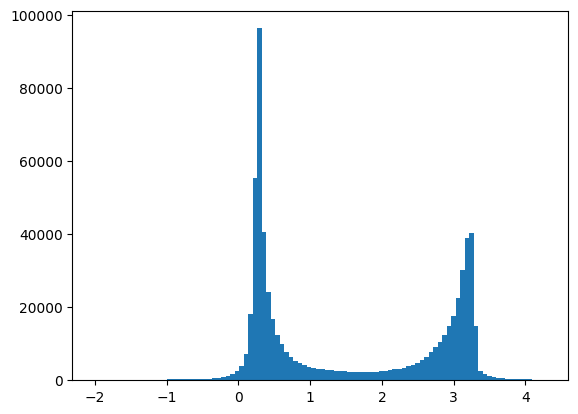

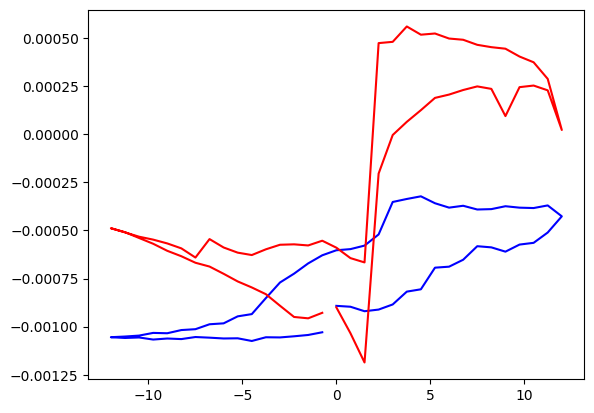

In [4]:
h5_sho_fit = main_dsets[1]
amplitude = h5_sho_fit['Amplitude [V]']
phase = h5_sho_fit['Phase [rad]']
adjust = np.max(phase) - np.min(phase)
phase_wrap = []
for ii in range(phase.shape[0]):
    phase_wrap.append([x+adjust if x < -2 else x for x in phase[ii,:]])
phase = np.asarray(phase_wrap)

plt.figure()
plt.hist(phase.ravel(),bins=100)
PR_mat = amplitude*np.cos(phase)
PR_mat = -PR_mat.reshape(h5_sho_fit.pos_dim_sizes[0],h5_sho_fit.pos_dim_sizes[1],-1 )
plt.figure()
dc_vec_OF = h5_sho_fit.h5_spec_vals[0,:][np.logical_and(h5_sho_fit.h5_spec_vals[1,:]==0,h5_sho_fit.h5_spec_vals[2,:]==2)] # off field
dc_vec_IF = h5_sho_fit.h5_spec_vals[0,:][np.logical_and(h5_sho_fit.h5_spec_vals[1,:]==1,h5_sho_fit.h5_spec_vals[2,:]==2)] # on field

PR_OF = PR_mat[:,:,129::2] 
PR_IF = PR_mat[:,:,128::2] 

plt.plot(dc_vec_OF,PR_OF[10,10,:] , 'b-') 
plt.plot(dc_vec_IF,PR_IF[10,10,:] , 'r-') 

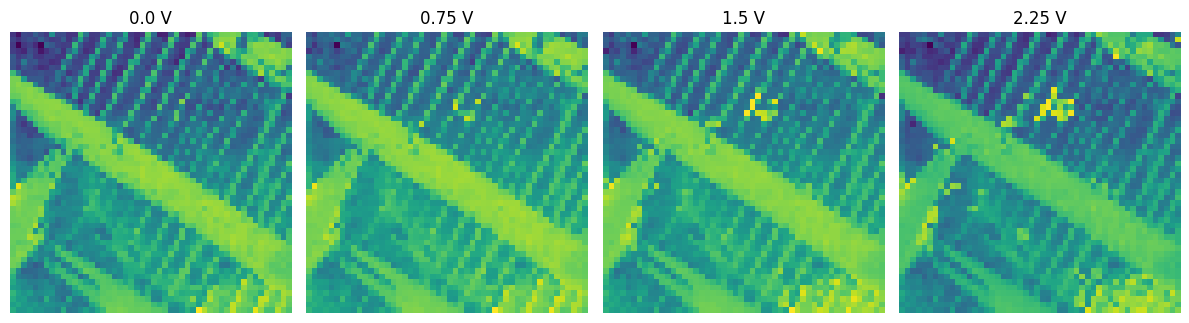

In [5]:
plt.figure(figsize=(12, 6))  

for ind in range(4):
    plt.subplot(1, 4, ind + 1) 
    plt.imshow(PR_OF[:, :, ind], cmap='viridis') 
    plt.title(str(dc_vec_OF[ind]) + ' V')
    plt.axis("off") 

plt.tight_layout()
plt.show()

In [8]:
import BGlib.be.analysis.be_loop_ncc as loop_ncc
from BGlib.be.analysis import be_loop_fitter

def prior_prop_loop_fitting(h5_f,dc_vec_OF,PR_mat, method = 'K-Means', NN = 1):
  from scipy.optimize import curve_fit
  from sklearn.metrics import r2_score
  from tqdm import trange
  from copy import deepcopy    
  from sklearn.cluster import KMeans
  import pyUSID as usid
  # import be_loop_fitter

  if method not in ['Random','Neighbor','K-Means','Hierarchical']:
    print('Please use one of the follwing methods: Random, Neighbor, Average, Mixed, K-Means, Hierarchical.')
    return

  cmap=plt.cm.plasma_r
  scale = (0,1)
  fig,ax = plt.subplots(figsize=(8,8))
  cbaxs = fig.add_axes([0.92,0.125,0.02,0.755])
  p0_refs = [[]]*PR_mat.shape[0]*PR_mat.shape[1]
  all_mean = np.mean(np.mean(PR_mat,axis=0),axis=0)
  
  bnds = (-100,100)
  p0_mat = [[]]*PR_mat.shape[0]*PR_mat.shape[1] # empty array to store fits from neighboring pixels
  fitted_loops_mat = [[]]*PR_mat.shape[0]*PR_mat.shape[1]
  SumSq = [[]]*PR_mat.shape[0]*PR_mat.shape[1]
  ref_counts = np.arange(PR_mat.shape[0]*PR_mat.shape[1]).reshape((PR_mat.shape[0],PR_mat.shape[1])) # reference for finding neighboring pixels
  count = -1
  # SET UP X DATA
  xdata0 = dc_vec_OF
  max_x = np.where(xdata0==np.max(xdata0))[0]
  if max_x != 0 or max_x != len(xdata0):
    xdata = np.roll(xdata0,-max_x) # assumes voltages are a symmetric triangle wave
    dum = 1
  else:
    xdata = xdata0 # just in case voltages are already rolled
    dum = 0

  p0_vals = []
  opt_vals = []
  res = []
  if dum == 1:
    all_mean = np.roll(all_mean,-max_x)

  if method == 'Neighbor' or method=='K-Means':
    for kk in range(20):
      p0 = np.random.normal(0.1,5,9)
      p0_vals.append(p0)
      try:
        vals_min, pcov = curve_fit(loop_ncc.loop_fit_function, xdata, all_mean, p0 = p0, maxfev = 10000)
      except:
        continue
      opt_vals.append(vals_min)
      fitted_loop = loop_ncc.loop_fit_function(xdata, *vals_min)
      yres = all_mean-fitted_loop
      res.append(yres@yres)

    popt = opt_vals[np.argmin(res)]
    popt_mean = deepcopy(popt)
    p0_mat = [popt]*PR_mat.shape[0]*PR_mat.shape[1]
    plt.figure()
    plt.plot(xdata,all_mean,'ko')
    fitted_loop = loop_ncc.loop_fit_function(xdata,*popt)
    plt.plot(xdata,fitted_loop,'k')
    print('Done with average fit')


  if method == 'K-Means':  #---> use average fit for start point for kmeans average fits
    size = PR_mat.shape[0]*PR_mat.shape[1]
    n_clusters = int(size/100)
    PR_mat_flat = PR_mat.reshape(size,int(PR_mat.shape[2]))
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(PR_mat_flat)
    labels = kmeans.labels_
    p0_clusters = []
    cluster_loops = []
    for pp in trange(n_clusters):
      opt_vals = []
      res = []
      clust = PR_mat_flat[labels==pp]
      PR_mean = np.mean(clust,axis=0)
      if dum==1:
        PR_mean = np.roll(PR_mean,-max_x)
      cluster_loops.append(PR_mean)
      p0 = p0_mat[0]
      try:
        popt, pcov = curve_fit(loop_ncc.loop_fit_function, xdata, PR_mean, p0 = p0, maxfev = 10000)
      except:
        kk = 0
        p0 = np.random.normal(0.1,5,9)
        while kk < 20:
          try:
            vals_min, pcov = curve_fit(loop_ncc.loop_fit_function, xdata, all_mean, p0 = p0, maxfev = 10000)
          except:
            continue
          kk +=1
          opt_vals.append(vals_min)
          fitted_loop = loop_ncc.loop_fit_function(xdata, *vals_min)
          yres = PR_mean-fitted_loop
          res.append(yres@yres)
          popt = opt_vals[np.argmin(res)]
      p0_clusters.append(popt)
      fitted_loop = loop_ncc.loop_fit_function(xdata, *popt)

  if method == 'Hierarchical':
    expt_type = usid.hdf_utils.get_attr(h5_f, 'data_type')
    h5_main = usid.hdf_utils.find_dataset(h5_f, 'Raw_Data')[0]
    h5_meas_grp = h5_main.parent.parent
    vs_mode = usid.hdf_utils.get_attr(h5_meas_grp, 'VS_mode')
    vs_cycle_frac = usid.hdf_utils.get_attr(h5_meas_grp, 'VS_cycle_fraction')
    max_cores = 1
    # Do the Loop Fitting on the SHO Fit dataset
    h5_loop_group = None
    loop_fitter = be_loop_fitter.BELoopFitter(h5_sho_fit, expt_type, vs_mode, vs_cycle_frac,
                                          cores=max_cores, h5_target_group=h5_loop_group, 
                                          verbose=False)
    loop_fitter.set_up_guess()
    h5_loop_guess = loop_fitter.do_guess(override=True)
    # Calling explicitely here since Fitter won't do it automatically
    h5_guess_loop_parms = loop_fitter.extract_loop_parameters(h5_loop_guess)

    loop_fitter.set_up_fit()
    h5_loop_fit = loop_fitter.do_fit(override=True)
    h5_loop_group = h5_loop_fit.parent
#-----------------
# Start loop for fitting each pixel
#-----------------
  for ii in trange(PR_mat.shape[0]):
    xind = ii
    for jj in range(PR_mat.shape[1]):
      count += 1 # used to keep track of popt vals
      yind = jj
      ydata0 = PR_mat[xind,yind,:]
      if dum == 1:
        ydata = np.roll(ydata0,-max_x)
      else:
        ydata = ydata0

#-----------------
# SET UP METHOD FOR INITIAL VALUES
#-----------------

#----------------- Random Guess

      if method == 'Random': # Random guesses of parameter values (may change initial values to random values within bounds)
        opt_vals = []
        res = []
        p0_vals = []
        kk=0
        while kk < 2:
          p0 = np.random.normal(0.1,5,9)
          p0_vals.append(p0)
          try:
            vals_min, pcov = curve_fit(loop_ncc.loop_fit_function, xdata, ydata, p0 = p0, maxfev = 10000)
          except:
            continue
          kk+=1
          opt_vals.append(vals_min)
          fitted_loop = loop_ncc.loop_fit_function(xdata, *vals_min)
          yres = ydata-fitted_loop
          res.append(yres@yres)
        popt = opt_vals[np.argmin(res)]
        p0_mat[count] = popt

#----------------- Neighbor informs guess
      if method == 'Neighbor':
        xs = [ ii+k for k in range(-NN,NN+1)]
        ys = [ jj+k for k in range(-NN,NN+1)]
        nbrs = [(n,m) for n in xs for m in ys]
        cond = [all(x >= 0 for x in list(y)) for y in nbrs]
        nbrs = [d for (d,remove) in zip(nbrs,cond) if remove]
        cond2 = [all(x < ref_counts.shape[0] for x in list(y)) for y in nbrs] # assumes PR_mat is square....
        nbrs = [d for (d,remove) in zip(nbrs,cond2) if remove]
        NN_indx = [ref_counts[v] for v in nbrs]
        prior_coefs = [p0_mat[k] for k in NN_indx if len(p0_mat[k]) != 0]
        if prior_coefs == []:
          p0 = popt
        else:
          p0 = np.mean(prior_coefs,axis=0)
        p0_refs[count] = p0
        try:
          popt, pcov = curve_fit(loop_ncc.loop_fit_function, xdata, ydata, p0 = p0, maxfev = 10000,bounds = bnds)
        except:
          fitted_loop = loop_ncc.loop_fit_function(xdata, *p0)
          plt.figure()
          plt.plot(xdata,fitted_loop,'r')
          plt.plot(xdata,ydata,'k')
          continue
        p0_mat[count] = popt # saves fitted coefficients for the index


#----------------- Hierarchical 
      if method == 'Hierarchical':
        p0 = np.asarray(list(h5_loop_fit[count][0]))
        p0_refs[count] = p0

        try:
          popt, pcov = curve_fit(loop_ncc.loop_fit_function, xdata, ydata, p0 = p0, maxfev = 10000,bounds = bnds)
        except:
          continue
        p0_mat[count] = popt

#----------------- K-Means
      if method == 'K-Means':
        lab = labels[count]
        p0 = p0_clusters[lab]
        try:
          popt, pcov = curve_fit(loop_ncc.loop_fit_function, xdata, ydata, p0 = p0, maxfev = 10000)
        except:
          p0 = popt_mean
          try:
            popt, pcov = curve_fit(loop_ncc.loop_fit_function, xdata, ydata, p0 = p0, maxfev = 10000)
          except:
            continue
        p0_refs[count] = p0
        p0_mat[count] = popt # saves fitted coefficients for the index
        fitted_loop = loop_ncc.loop_fit_function(xdata, *p0_mat[count])
        fitted_loops_mat[count] = fitted_loop
        ss = r2_score(ydata,fitted_loop)
        SumSq[count] = ss
        sh = np.floor(1+(2**16-1)*((ss)-scale[0])/(scale[1]-scale[0]))
        if sh<1:
            sh=1
        if sh>2**16:
            sh = 2**16
        
        cz = ax.plot(ii,jj,c=cmap(sh/(2**16)),marker='s',markersize=7)
    scbar = plt.cm.ScalarMappable(cmap=plt.cm.plasma_r,norm=plt.Normalize(vmin=scale[0],vmax=scale[1]))
    scbar._A=[]
    cbar = plt.colorbar(scbar,cax=cbaxs)
    cbar.ax.set_ylabel('$R^2$',rotation=270,labelpad=20)

    return fig,ax,p0_refs,p0_mat,SumSq,fitted_loops_mat


In [7]:
field_names = ['V+', 'V-', 'Imprint', 'R+', 'R-', 'Switchable Polarization',
               'Work of Switching', 'Nucleation Bias 1', 'Nucleation Bias 2']
switching32 = np.dtype({'names': field_names,
                        'formats': [np.float32 for name in field_names]})

In [11]:
from scipy.special import erfinv

def loop_fit_function(vdc, *coef_vec):
    """
    9 parameter fit function
    
    Parameters
    -----------
    vdc : 1D numpy array or list
        DC voltages
    coef_vec : 1D numpy array or list
        9 parameter coefficient vector
        
    Returns
    ---------
    loop_eval : 1D numpy array
        Loop values
    """
    from scipy.special import erf
    a = coef_vec[:5]
    b = coef_vec[5:]
    d = 1000

    v1 = np.asarray(vdc[:int(len(vdc) / 2)])
    v2 = np.asarray(vdc[int(len(vdc) / 2):])

    g1 = (b[1] - b[0]) / 2 * (erf((v1 - a[2]) * d) + 1) + b[0]
    g2 = (b[3] - b[2]) / 2 * (erf((v2 - a[3]) * d) + 1) + b[2]

    y1 = (g1 * erf((v1 - a[2]) / g1) + b[0]) / (b[0] + b[1])
    y2 = (g2 * erf((v2 - a[3]) / g2) + b[2]) / (b[2] + b[3])

    f1 = a[0] + a[1] * y1 + a[4] * v1
    f2 = a[0] + a[1] * y2 + a[4] * v2

    loop_eval = np.hstack((f1, f2))
    return loop_eval


def loop_resid(coef_vec,vdc, ydata):
    y = loop_fit_function(vdc,*coef_vec)
    res = ydata-y
    ss = res@res
    return ss


# Will need to vectorize double for loop to make faster, but making sure it works first

def prior_prop_loop_fitting(h5_f,dc_vec_OF,PR_mat, method = 'K-Means', NN = 1):
  from scipy.optimize import curve_fit
  from sklearn.metrics import r2_score
  from tqdm import trange
  from copy import deepcopy    
  from sklearn.cluster import KMeans
  import pyUSID as usid
  # import be_loop_fitter

  if method not in ['Random','Neighbor','K-Means','Hierarchical']:
    print('Please use one of the follwing methods: Random, Neighbor, Average, Mixed, K-Means, Hierarchical.')
    return

  cmap=plt.cm.plasma_r
  scale = (0,1)
  fig,ax = plt.subplots(figsize=(8,8))
  cbaxs = fig.add_axes([0.92,0.125,0.02,0.755])
  p0_refs = [[]]*PR_mat.shape[0]*PR_mat.shape[1]
  all_mean = np.mean(np.mean(PR_mat,axis=0),axis=0)
  
  bnds = (-100,100)
  p0_mat = [[]]*PR_mat.shape[0]*PR_mat.shape[1] # empty array to store fits from neighboring pixels
  fitted_loops_mat = [[]]*PR_mat.shape[0]*PR_mat.shape[1]
  SumSq = [[]]*PR_mat.shape[0]*PR_mat.shape[1]
  ref_counts = np.arange(PR_mat.shape[0]*PR_mat.shape[1]).reshape((PR_mat.shape[0],PR_mat.shape[1])) # reference for finding neighboring pixels
  count = -1
  # SET UP X DATA
  xdata0 = dc_vec_OF
  max_x = np.where(xdata0==np.max(xdata0))[0]
  if max_x != 0 or max_x != len(xdata0):
    xdata = np.roll(xdata0,-max_x) # assumes voltages are a symmetric triangle wave
    dum = 1
  else:
    xdata = xdata0 # just in case voltages are already rolled
    dum = 0

  p0_vals = []
  opt_vals = []
  res = []
  if dum == 1:
    all_mean = np.roll(all_mean,-max_x)

  if method == 'Neighbor' or method=='K-Means':
    for kk in range(20):
      p0 = np.random.normal(0.1,5,9)
      p0_vals.append(p0)
      try:
        vals_min, pcov = curve_fit(loop_fit_function, xdata, all_mean, p0 = p0, maxfev = 10000)
      except:
        continue
      opt_vals.append(vals_min)
      fitted_loop = loop_fit_function(xdata, *vals_min)
      yres = all_mean-fitted_loop
      res.append(yres@yres)

    popt = opt_vals[np.argmin(res)]
    popt_mean = deepcopy(popt)
    p0_mat = [popt]*PR_mat.shape[0]*PR_mat.shape[1]
    plt.figure()
    plt.plot(xdata,all_mean,'ko')
    fitted_loop = loop_fit_function(xdata,*popt)
    plt.plot(xdata,fitted_loop,'k')
    print('Done with average fit')


  if method == 'K-Means':  #---> use average fit for start point for kmeans average fits
    size = PR_mat.shape[0]*PR_mat.shape[1]
    n_clusters = int(size/100)
    PR_mat_flat = PR_mat.reshape(size,int(PR_mat.shape[2]))
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(PR_mat_flat)
    labels = kmeans.labels_
    p0_clusters = []
    cluster_loops = []
    for pp in trange(n_clusters):
      opt_vals = []
      res = []
      clust = PR_mat_flat[labels==pp]
      PR_mean = np.mean(clust,axis=0)
      if dum==1:
        PR_mean = np.roll(PR_mean,-max_x)
      cluster_loops.append(PR_mean)
      p0 = p0_mat[0]
      try:
        popt, pcov = curve_fit(loop_fit_function, xdata, PR_mean, p0 = p0, maxfev = 10000)
      except:
        kk = 0
        p0 = np.random.normal(0.1,5,9)
        while kk < 20:
          try:
            vals_min, pcov = curve_fit(loop_fit_function, xdata, all_mean, p0 = p0, maxfev = 10000)
          except:
            continue
          kk +=1
          opt_vals.append(vals_min)
          fitted_loop = loop_fit_function(xdata, *vals_min)
          yres = PR_mean-fitted_loop
          res.append(yres@yres)
          popt = opt_vals[np.argmin(res)]
      p0_clusters.append(popt)
      fitted_loop = loop_fit_function(xdata, *popt)

  if method == 'Hierarchical':
    expt_type = usid.hdf_utils.get_attr(h5_f, 'data_type')
    h5_main = usid.hdf_utils.find_dataset(h5_f, 'Raw_Data')[0]
    h5_meas_grp = h5_main.parent.parent
    vs_mode = usid.hdf_utils.get_attr(h5_meas_grp, 'VS_mode')
    vs_cycle_frac = usid.hdf_utils.get_attr(h5_meas_grp, 'VS_cycle_fraction')
    max_cores = 1
    # Do the Loop Fitting on the SHO Fit dataset
    h5_loop_group = None
    loop_fitter = be_loop_fitter.BELoopFitter(h5_sho_fit, expt_type, vs_mode, vs_cycle_frac,
                                          cores=max_cores, h5_target_group=h5_loop_group, 
                                          verbose=False)
    loop_fitter.set_up_guess()
    h5_loop_guess = loop_fitter.do_guess(override=True)
    # Calling explicitely here since Fitter won't do it automatically
    h5_guess_loop_parms = loop_fitter.extract_loop_parameters(h5_loop_guess)

    loop_fitter.set_up_fit()
    h5_loop_fit = loop_fitter.do_fit(override=True)
    h5_loop_group = h5_loop_fit.parent
#-----------------
# Start loop for fitting each pixel
#-----------------
  for ii in trange(PR_mat.shape[0]):
    xind = ii
    for jj in range(PR_mat.shape[1]):
      count += 1 # used to keep track of popt vals
      yind = jj
      ydata0 = PR_mat[xind,yind,:]
      if dum == 1:
        ydata = np.roll(ydata0,-max_x)
      else:
        ydata = ydata0

#-----------------
# SET UP METHOD FOR INITIAL VALUES
#-----------------

#----------------- Random Guess

      if method == 'Random': # Random guesses of parameter values (may change initial values to random values within bounds)
        opt_vals = []
        res = []
        p0_vals = []
        kk=0
        while kk < 2:
          p0 = np.random.normal(0.1,5,9)
          p0_vals.append(p0)
          try:
            vals_min, pcov = curve_fit(loop_fit_function, xdata, ydata, p0 = p0, maxfev = 10000)
          except:
            continue
          kk+=1
          opt_vals.append(vals_min)
          fitted_loop = loop_fit_function(xdata, *vals_min)
          yres = ydata-fitted_loop
          res.append(yres@yres)
        popt = opt_vals[np.argmin(res)]
        p0_mat[count] = popt

#----------------- Neighbor informs guess
      if method == 'Neighbor':
        xs = [ ii+k for k in range(-NN,NN+1)]
        ys = [ jj+k for k in range(-NN,NN+1)]
        nbrs = [(n,m) for n in xs for m in ys]
        cond = [all(x >= 0 for x in list(y)) for y in nbrs]
        nbrs = [d for (d,remove) in zip(nbrs,cond) if remove]
        cond2 = [all(x < ref_counts.shape[0] for x in list(y)) for y in nbrs] # assumes PR_mat is square....
        nbrs = [d for (d,remove) in zip(nbrs,cond2) if remove]
        NN_indx = [ref_counts[v] for v in nbrs]
        prior_coefs = [p0_mat[k] for k in NN_indx if len(p0_mat[k]) != 0]
        if prior_coefs == []:
          p0 = popt
        else:
          p0 = np.mean(prior_coefs,axis=0)
        p0_refs[count] = p0
        try:
          popt, pcov = curve_fit(loop_fit_function, xdata, ydata, p0 = p0, maxfev = 10000,bounds = bnds)
        except:
          fitted_loop = loop_fit_function(xdata, *p0)
          plt.figure()
          plt.plot(xdata,fitted_loop,'r')
          plt.plot(xdata,ydata,'k')
          continue
        p0_mat[count] = popt # saves fitted coefficients for the index


#----------------- Hierarchical 
      if method == 'Hierarchical':
        p0 = np.asarray(list(h5_loop_fit[count][0]))
        p0_refs[count] = p0

        try:
          popt, pcov = curve_fit(loop_fit_function, xdata, ydata, p0 = p0, maxfev = 10000,bounds = bnds)
        except:
          continue
        p0_mat[count] = popt

#----------------- K-Means
      if method == 'K-Means':
        lab = labels[count]
        p0 = p0_clusters[lab]
        try:
          popt, pcov = curve_fit(loop_fit_function, xdata, ydata, p0 = p0, maxfev = 10000)
        except:
          p0 = popt_mean
          try:
            popt, pcov = curve_fit(loop_fit_function, xdata, ydata, p0 = p0, maxfev = 10000)
          except:
            continue
        p0_refs[count] = p0
        p0_mat[count] = popt # saves fitted coefficients for the index



#-----------------
#----------------- Common for all methods ---------------------
#-----------------

      fitted_loop = loop_fit_function(xdata, *p0_mat[count])
      fitted_loops_mat[count] = fitted_loop
      ss = r2_score(ydata,fitted_loop)
      SumSq[count] = ss
      sh = np.floor(1+(2**16-1)*((ss)-scale[0])/(scale[1]-scale[0]))
      if sh<1:
        sh=1
      if sh>2**16:
        sh = 2**16
      
      cz = ax.plot(ii,jj,c=cmap(sh/(2**16)),marker='s',markersize=7)

  scbar = plt.cm.ScalarMappable(cmap=plt.cm.plasma_r,norm=plt.Normalize(vmin=scale[0],vmax=scale[1]))
  scbar._A=[]
  cbar = plt.colorbar(scbar,cax=cbaxs)
  cbar.ax.set_ylabel('$R^2$',rotation=270,labelpad=20)

  return fig,ax,p0_refs,p0_mat,SumSq,fitted_loops_mat


def calc_switching_coef_vec(loop_coef_vec, nuc_threshold):
    """
    Calculates the physical loop parameters from the array of loop parameters.
    Parameters
    ----------
    loop_coef_vec : numpy.ndarray
        Array of loop coeffiecients
    nuc_threshold : float
        Nucleation threshold
    Returns
    -------
    switching_coef_vec : numpy.ndarray
        Array of loop parameters
    """
    switching_coef_vec = np.zeros(shape=loop_coef_vec.shape[0], dtype=switching32)

    anv = loop_coef_vec[:, :5].T
    bnv = loop_coef_vec[:, 5:].T

    nuc_v01a = bnv[2] * erfinv((nuc_threshold * bnv[2] + nuc_threshold * bnv[3] - bnv[2]) / bnv[2]) + anv[3]
    nuc_v01b = bnv[3] * erfinv((nuc_threshold * bnv[2] + nuc_threshold * bnv[3] - bnv[2]) / bnv[3]) + anv[3]

    nuc_v01 = np.where(np.isfinite(nuc_v01a), nuc_v01a,
                       np.where(np.isfinite(nuc_v01b), nuc_v01b, -1E-10))

    nuc_v02a = bnv[0] * erfinv(((1 - nuc_threshold) * bnv[0] + (1 - nuc_threshold) * bnv[1] - bnv[0]) / bnv[0]) + anv[2]
    nuc_v02b = bnv[1] * erfinv(((1 - nuc_threshold) * bnv[0] + (1 - nuc_threshold) * bnv[1] - bnv[0]) / bnv[1]) + anv[2]

    nuc_v02 = np.where(np.isfinite(nuc_v02a), nuc_v02a,
                       np.where(np.isfinite(nuc_v02b), nuc_v02b, -1E-10))

    switching_coef_vec['V+'] = loop_coef_vec[:, 3]
    switching_coef_vec['V-'] = loop_coef_vec[:, 2]
    switching_coef_vec['Imprint'] = (loop_coef_vec[:, 2] + loop_coef_vec[:, 3]) / 2
    switching_coef_vec['R+'] = loop_coef_vec[:, 0] + loop_coef_vec[:, 1]
    switching_coef_vec['R-'] = loop_coef_vec[:, 0]
    switching_coef_vec['Switchable Polarization'] = loop_coef_vec[:, 1]
    switching_coef_vec['Work of Switching'] = np.abs(loop_coef_vec[:, 3] -
                                                     loop_coef_vec[:, 2]) * np.abs(loop_coef_vec[:, 1])

    switching_coef_vec['Nucleation Bias 1'] = nuc_v01
    switching_coef_vec['Nucleation Bias 2'] = nuc_v02

    return switching_coef_vec.reshape([-1, 1])
field_names = ['V+', 'V-', 'Imprint', 'R+', 'R-', 'Switchable Polarization',
               'Work of Switching', 'Nucleation Bias 1', 'Nucleation Bias 2']
switching32 = np.dtype({'names': field_names,
                        'formats': [np.float32 for name in field_names]})

C:\Users\pmsda\AppData\Local\Temp\ipykernel_11772\1553056073.py:30: RuntimeWarning: divide by zero encountered in divide
  y1 = (g1 * erf((v1 - a[2]) / g1) + b[0]) / (b[0] + b[1])
c:\Users\pmsda\anaconda3\envs\pycro_env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Done with average fit


  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\pmsda\AppData\Local\Temp\ipykernel_11772\1553056073.py:30: RuntimeWarning: divide by zero encountered in divide
  y1 = (g1 * erf((v1 - a[2]) / g1) + b[0]) / (b[0] + b[1])
C:\Users\pmsda\AppData\Local\Temp\ipykernel_11772\1553056073.py:30: RuntimeWarning: divide by zero encountered in divide
  y1 = (g1 * erf((v1 - a[2]) / g1) + b[0]) / (b[0] + b[1])
C:\Users\pmsda\AppData\Local\Temp\ipykernel_11772\1553056073.py:31: RuntimeWarning: divide by zero encountered in divide
  y2 = (g2 * erf((v2 - a[3]) / g2) + b[2]) / (b[2] + b[3])
C:\Users\pmsda\AppData\Local\Temp\ipykernel_11772\1553056073.py:31: RuntimeWarning: divide by zero encountered in divide
  y2 = (g2 * erf((v2 - a[3]) / g2) + b[2]) / (b[2] + b[3])
  2%|▏         | 1/50 [00:21<17:09, 21.01s/it]C:\Users\pmsda\AppData\Local\Temp\ipykernel_11772\1553056073.py:30: RuntimeWarning: divide by zero encountered in divide
  y1 = (g1 * erf((v1 - a[2]) / g1) + b[0]) / (b[0] + b[1])
C:\Users\pmsda\A

814.3837127685547


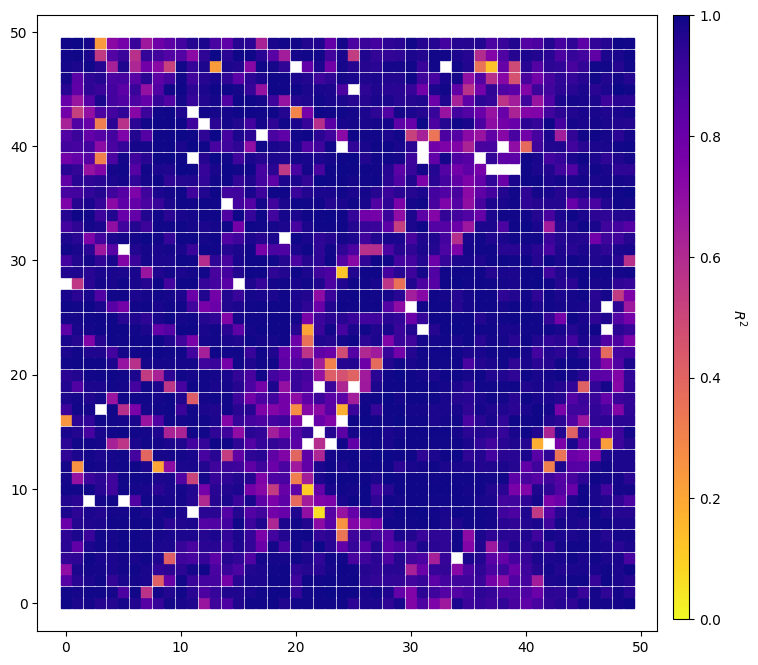

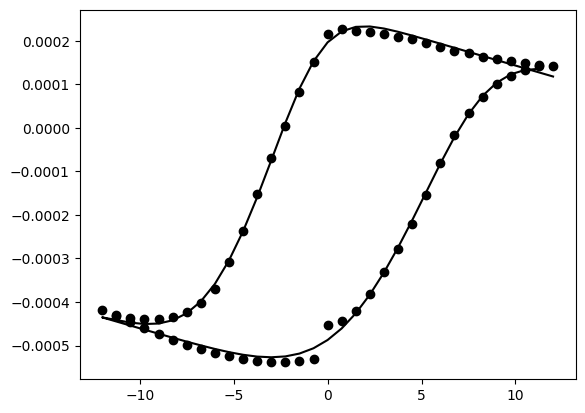

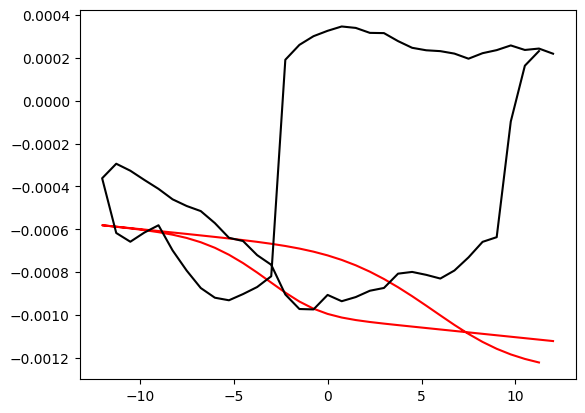

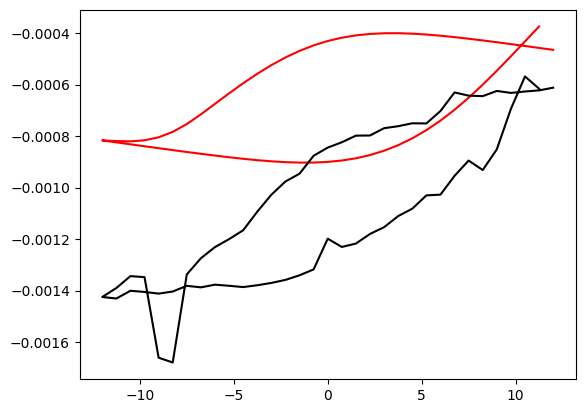

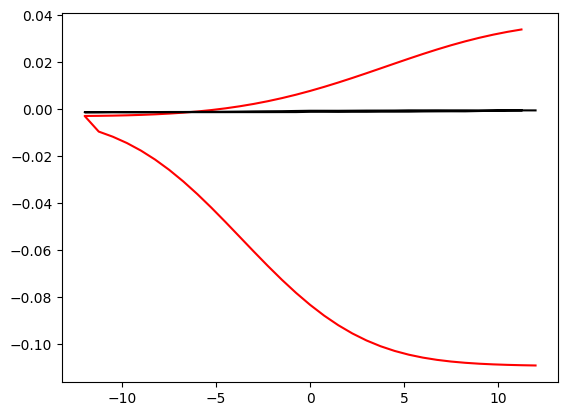

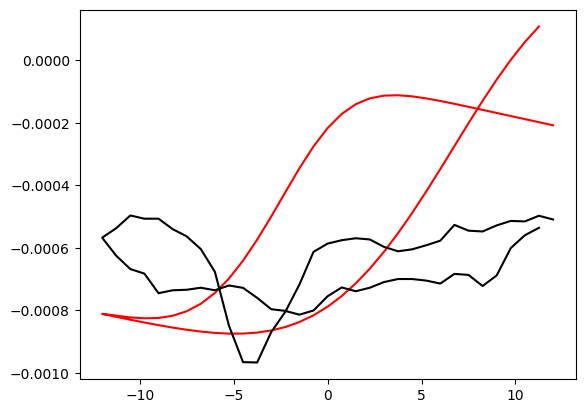

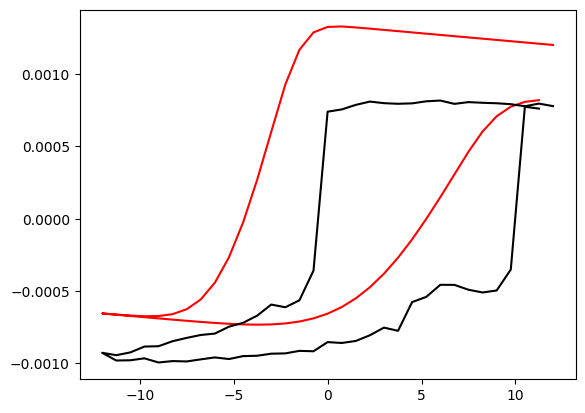

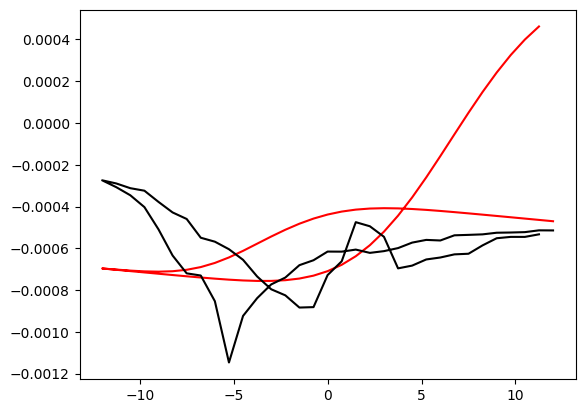

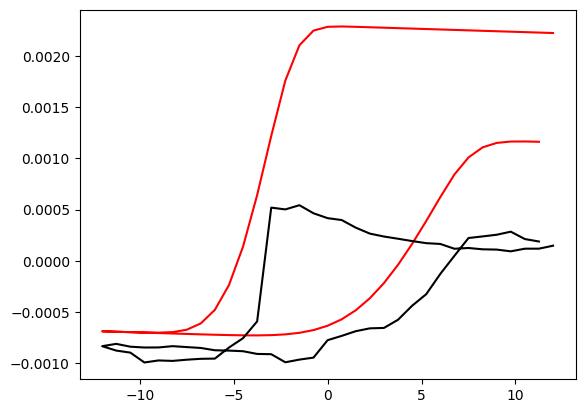

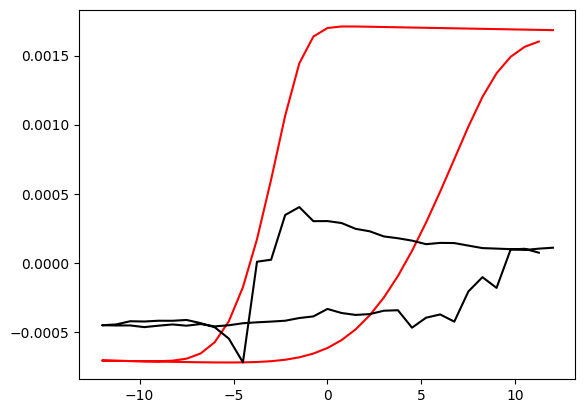

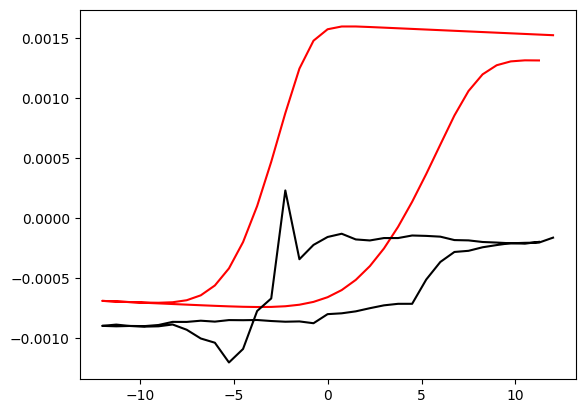

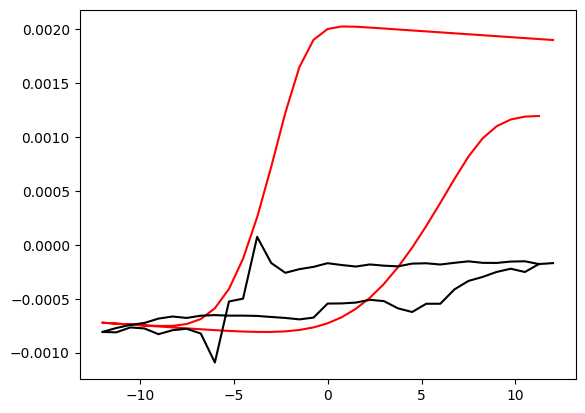

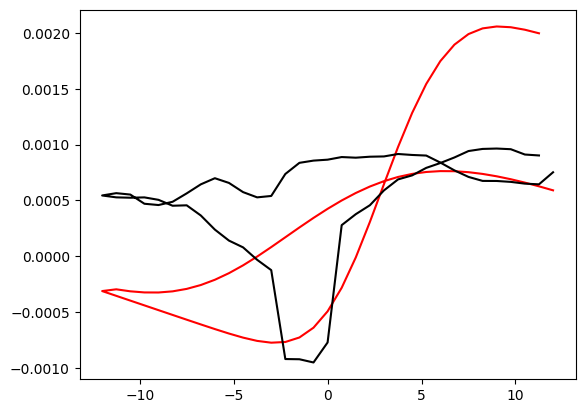

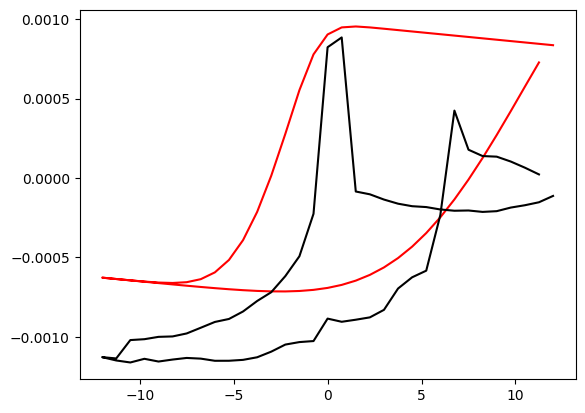

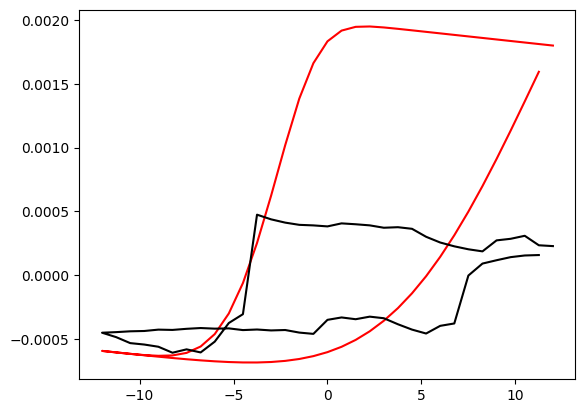

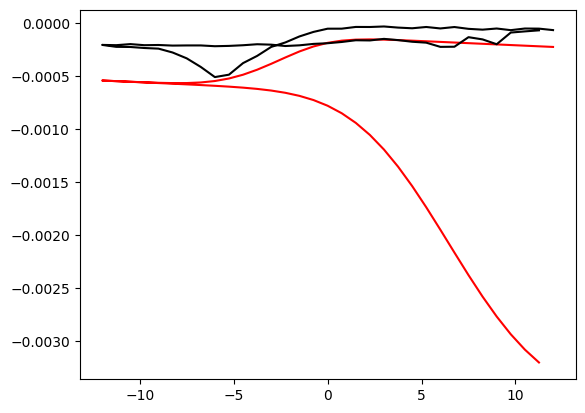

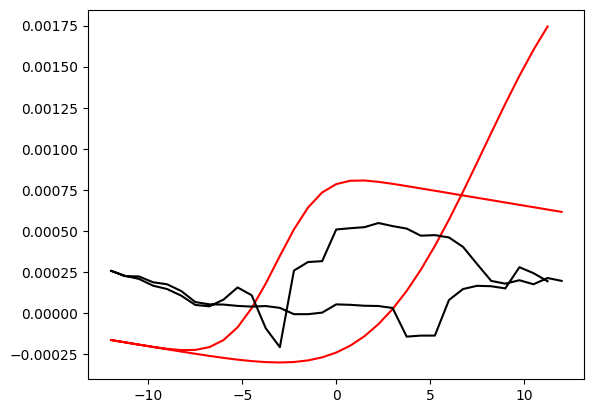

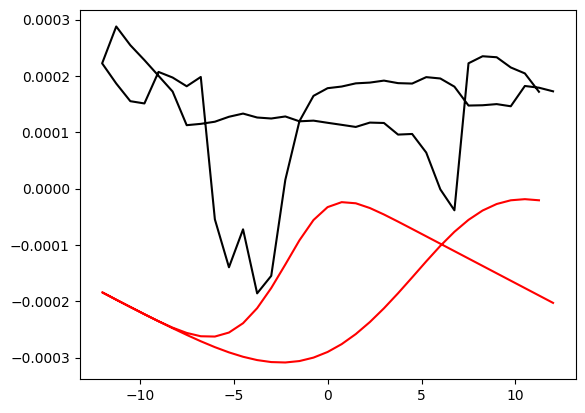

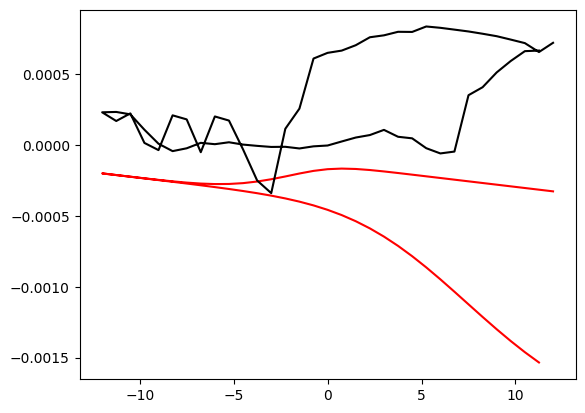

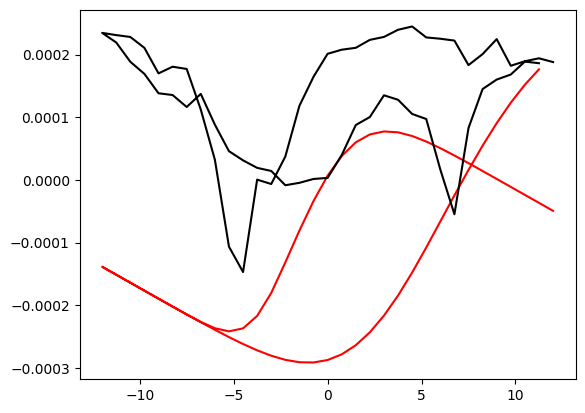

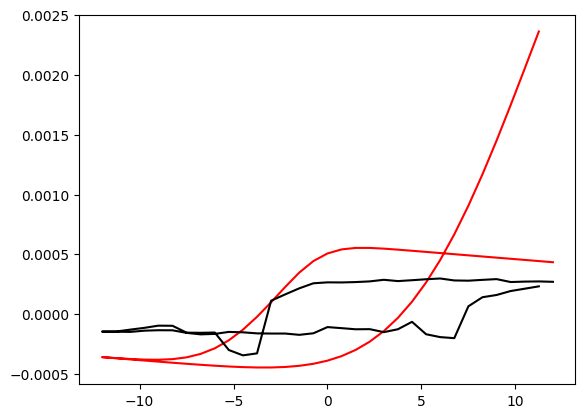

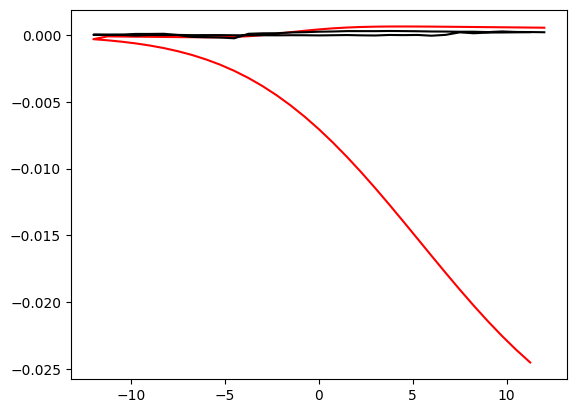

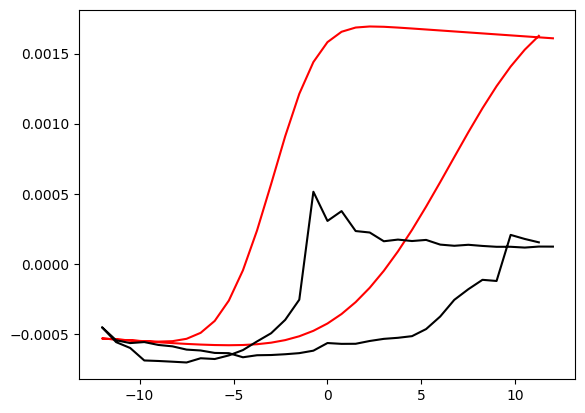

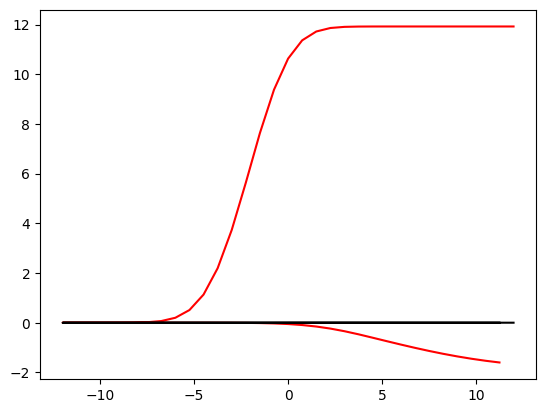

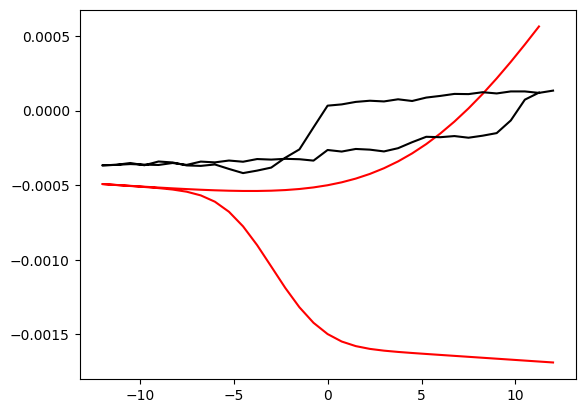

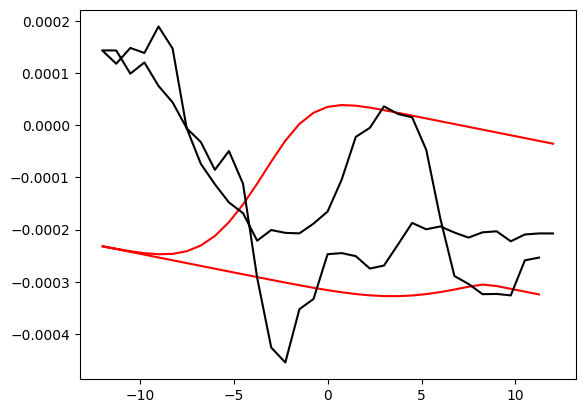

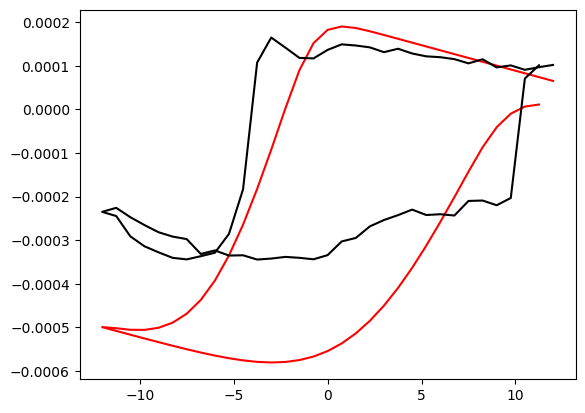

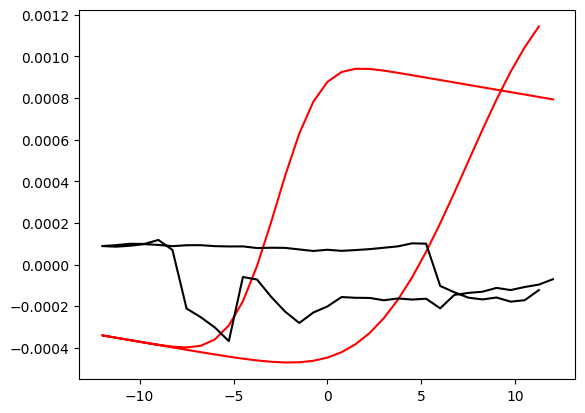

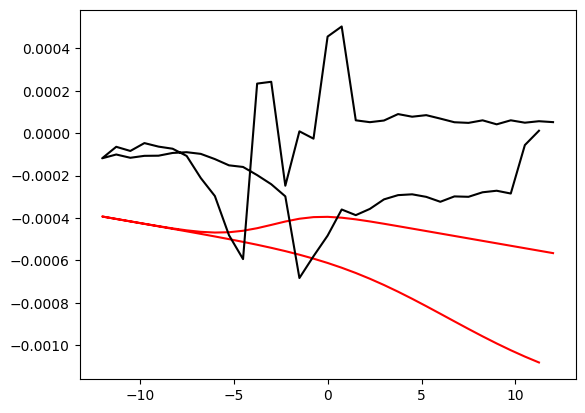

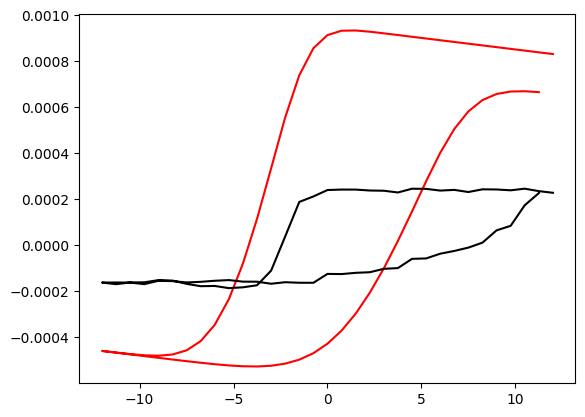

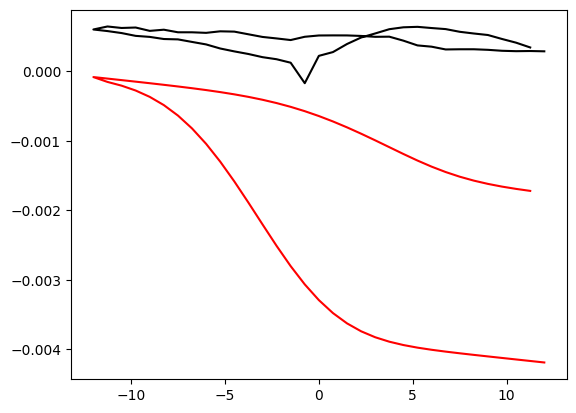

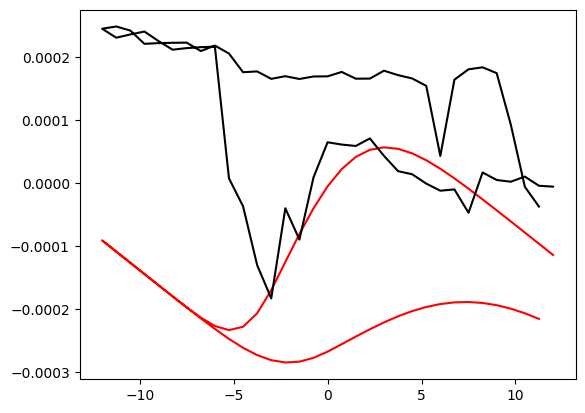

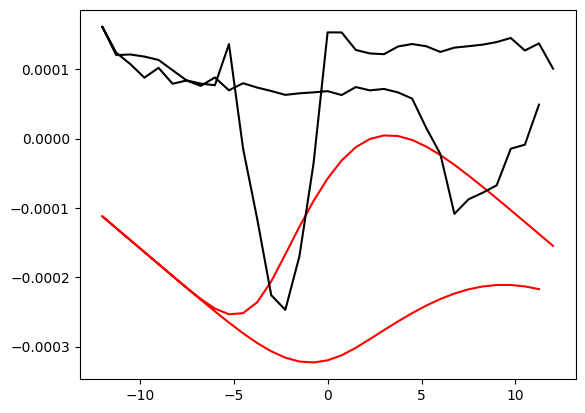

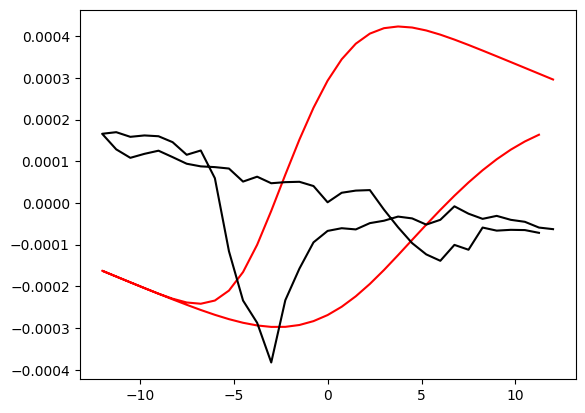

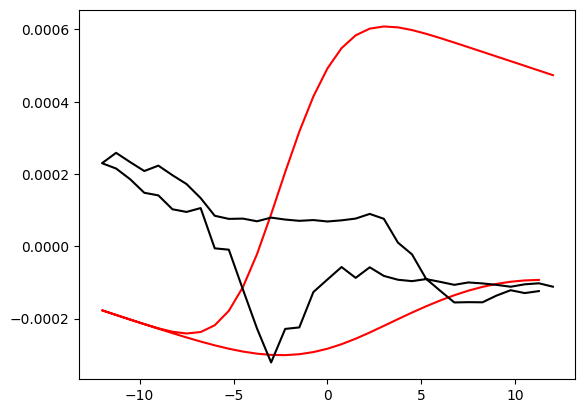

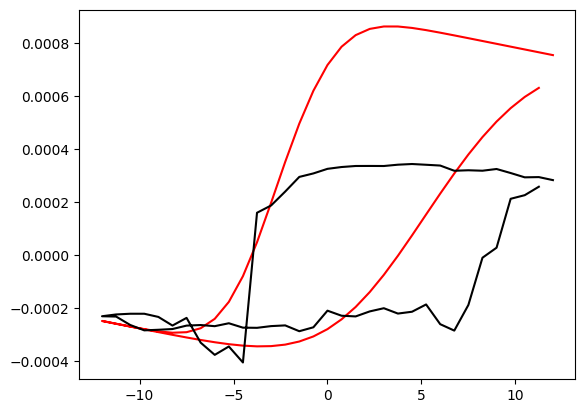

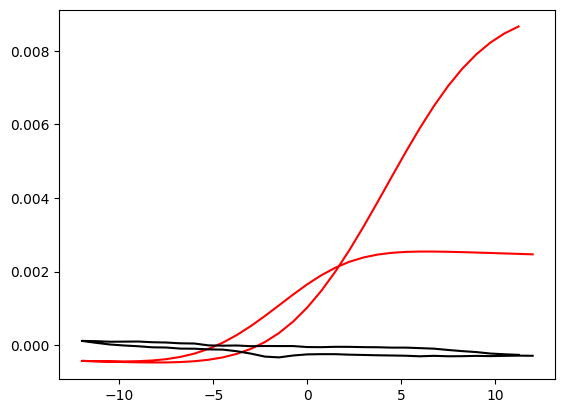

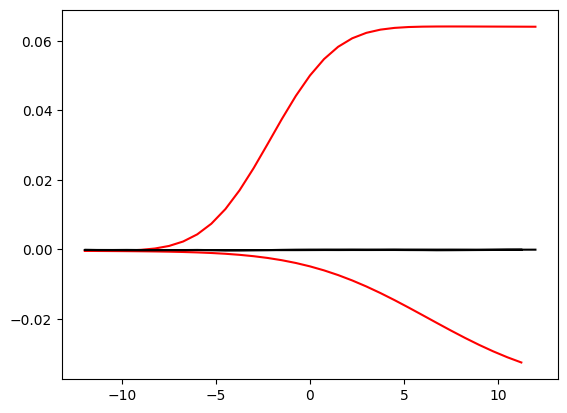

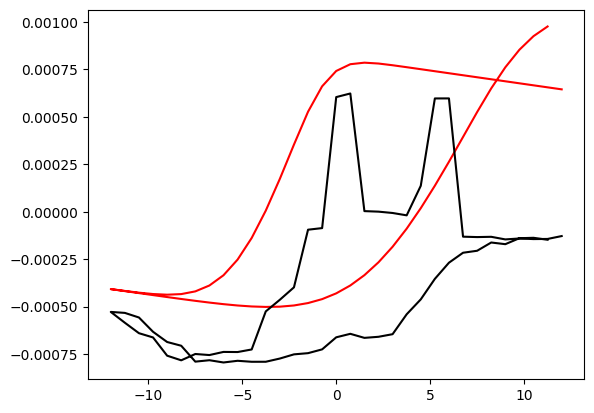

In [12]:
start = time.time()
fig,ax,p0_refs,p0_mat,SumSq,fitted_loops_mat=prior_prop_loop_fitting(h5_file,dc_vec_OF,PR_OF, method = 'Neighbor',NN=2)
end = time.time()
elapsed_time = end-start
print(elapsed_time)